In [47]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import torch
from ocd.models.no_permutation import OCDAF

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import lightning
from lightning_toolbox import TrainingModule
from lightning_toolbox.data import DataModule
from ocd.data.module import OCDDataModule
# from lightning_toolbox.data import DataModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


x(2) = gaussian(0.00, 1.00) * exp(sigmoid(8.93)) + sigmoid(3.90)
---------------------

x(0) = gaussian(0.00, 1.00) * exp(sigmoid(x(2) * 0.67 + 2.13)) + sigmoid(x(2) * 19.11 + 7.00)
---------------------

x(1) = gaussian(0.00, 1.00) * exp(sigmoid(x(0) * 12.42 + 5.06)) + sigmoid(x(0) * 10.08 + 1.17)
---------------------



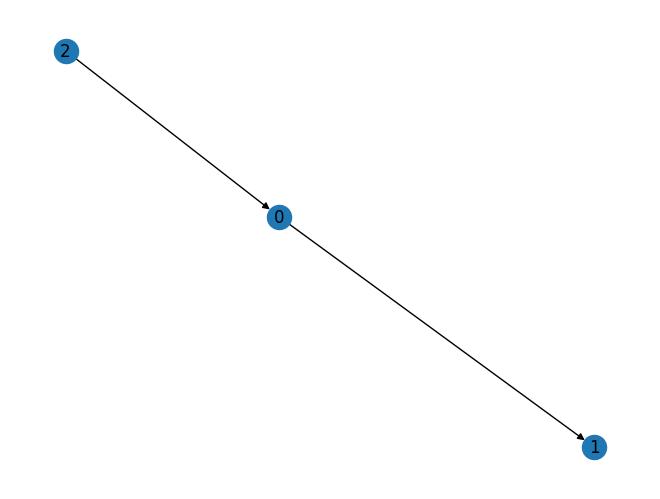

In [16]:
## Synthetic scm arguments
scm_generator_class = 'ocd.data.affine_additive.scm.AffineAdditiveSCMGenerator'

dims = 3
observation_size=10240
# an example of a generation scheme:
graph_generation_scheme = dict(
    graph_generator_type='chain',
    graph_generator_args=dict(
        n=dims,
    )
)

# scm_generator kwargs
scm_generator_kwargs = dict(
    **graph_generation_scheme,
    # function_type="linear_additive",
    function_type="linear_affine_with_exp_modulatd",
    noise_type='gaussian',
    functional_form_generator_args=dict(
        weight_low=0.5,
        weight_high=20,
        noise_std_low=1.0,
        noise_std_high=1.0,
        noise_mean_low=0.0,
        noise_mean_high=0.0
    )
)


dm = OCDDataModule(
    seed=100,
    scm_generator_class=scm_generator_class,
    scm_generator_args=scm_generator_kwargs,
    observation_size=observation_size,
    batch_size=1024,
    num_workers=0,  # set to 0 for no multiprocessing
    val_size=0.1,
)
dm.setup('fit')
dm.scm.draw()


In [26]:
data = dm.datasets[0].samples.to_numpy()

In [62]:

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sample(n):
    # generate x2 = gaussian(0.00, 1.00) * exp(sigmoid(8.93)) + sigmoid(3.90)
    x2 =  np.random.normal(0.00, 1.00, n) * np.exp(sigmoid(8.93)) + sigmoid(3.90)
    # generate x0 =  gaussian(0.00, 1.00) * exp(sigmoid(x(2) * 0.67 + 2.13)) + sigmoid(x(2) * 19.11 + 7.00)
    x0 = np.random.normal(0.00, 1.00, n) * np.exp(sigmoid(x2 * 0.67 + 2.13)) + sigmoid(x2 * 19.11 + 7.00)
    # generate x1 = gaussian(0.00, 1.00) * exp(sigmoid(x(0) * 12.42 + 5.06)) + sigmoid(x(0) * 10.08 + 1.17)
    x1 = np.random.normal(0.00, 1.00, n) * np.exp(sigmoid((x0 + 0.5 * x2)  * 12.42 + 5.06)) + sigmoid((x0 + 2 * x2) * 10.08 + 1.17)
    # stack x0, x1, x2
    return np.stack([x0, x1, x2], axis=1)

data = sample(10240)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


dataset = Dataset(data)

In [68]:
from lightning.pytorch.loggers import TensorBoardLogger
# ordering = [2, 0 ,1][::-1]
# ordering = [0, 2, 1][::-1]
ordering = [0, 1, 2][::-1]
experiment_base = 'lightning_logs/'
max_epoch = 300


model = OCDAF(
    in_features=3,
    layers=[6, 9],
    additive=False,
    num_transforms=4,
    ordering=ordering
)

tm = TrainingModule(
    model=model,
    criterion_args=dict(nll="lambda batch, training_module: -training_module.model.log_prob(*training_module.model(batch)).mean()"),
    optimizer='torch.optim.Adam',
    lr=1e-3,
)
dm = DataModule(
    dataset=dataset,
    val_size=0.1,
    batch_size=1024,
)


experiment_name = f"[{','.join([str(i) for i in ordering])}]"
logger = TensorBoardLogger(experiment_base, name='trinary-vv-10k-trans', version=experiment_name)
trainer = lightning.Trainer(
    # accelerator='mps',
    logger=logger,
    log_every_n_steps=1,
    max_epochs=max_epoch,
    gradient_clip_val=1.0,
    gradient_clip_algorithm='value', 
    enable_progress_bar=False,
)
trainer.fit(tm, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 588   
--------------------------------
588       Trainable params
0         Non-trainable params
588       Total params
0.002     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=300` reached.


In [51]:
dm.setup('fit')
dl = dm.train_dataloader()
next(iter(dl)).shape

torch.Size([1024, 3])